In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/36h11/s_yaw_36h11_2m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,36.353335
1,0.341430,23.241653
2,1.063632,0.920764
3,1.465142,0.350840
4,1.831679,2.277590
...,...,...
770,94.847994,-0.303225
771,94.949836,-0.280187
772,96.056673,-0.204726
773,96.175978,-0.286676


<AxesSubplot:xlabel='relative_time'>

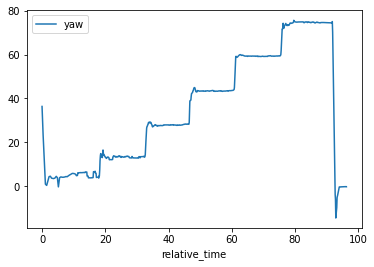

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

160

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

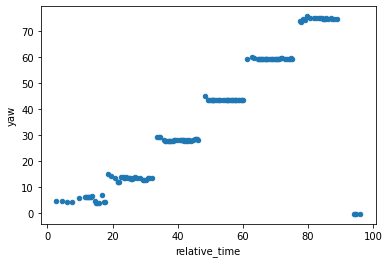

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
6,2.632546,4.534337,0
10,4.491226,4.483583,0
14,5.955687,4.233954,0
18,7.583418,4.411913,0
24,9.560922,5.819714,0
...,...,...,...
752,88.886383,74.622371,75
763,94.116472,-0.319508,0
766,94.428112,-0.326641,0
768,94.627957,-0.297383,0


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [13]:
# drop rows at the end
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets.relative_time > 89].index).reset_index()

In [14]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [15]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,index,relative_time,yaw,true_yaw,error
18,91,17.506239,4.104439,0,-4.104439
19,93,17.715459,4.111508,0,-4.111508
42,221,31.106229,13.440572,15,1.559428
43,232,32.211945,13.648127,15,1.351873
72,364,45.953869,28.370597,30,1.629403
73,367,46.257668,28.277313,30,1.722687
101,497,59.724215,43.553743,45,1.446257
102,500,60.039529,43.624194,45,1.375806
131,644,74.893098,59.428036,60,0.571964
132,646,75.108099,59.396254,60,0.603746


In [16]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,20.0,-5.223694,1.085263,-6.809421,-6.184451,-5.221672,-4.203342,-3.814595
15,24.0,1.450514,0.415964,0.148736,1.319870,1.483941,1.596240,2.105025
30,30.0,1.933100,0.421482,0.737064,1.856409,2.058447,2.135714,2.368420
45,29.0,1.486129,0.292366,0.033468,1.485329,1.544775,1.605575,1.677239
60,30.0,0.654052,0.165743,0.028675,0.633668,0.681911,0.746553,0.860583
75,20.0,0.333445,0.433672,-0.609397,0.123995,0.262005,0.414517,1.376997


In [17]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

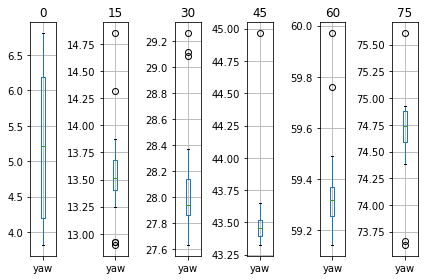

In [18]:
box_plotter(target)

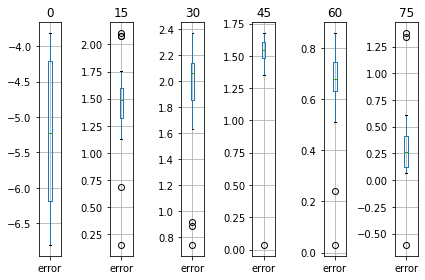

In [19]:
box_plotter('error')

In [20]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_36h11_720.csv')